In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

data_music = pd.read_csv("/Users/jongkyung/Desktop/SAC_ADAVANTK_DATA_202312.csv")

In [3]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']='AppleGothic'  #Mac용
#matplotlib.rcParam['font.family']='Malgun Gothic' 윈도우 용
matplotlib.rcParams['font.size']=15 #글자 크기
matplotlib.rcParams['axes.unicode_minus']=False #한글 폰트 사용 시, 마이너스 글자가 깨지는 현상을 해결

# 데이터 정규화
- 불필요한 데이터 삭제
- 컬럼명 변경
- 필요한 데이터 피쳐 새로 생성
- 결측치 처리

In [5]:
df = data_music.copy()
df = df.rename(columns={
    "PBLPRFR_NM" : "concert_name",
    "PBLPRFR_PLACE_NM" : "concert_place",
    "PBLPRFR_DE" : "concert_day",
    "PBLPRFR_TIME" : "concert_time",
    "GENRE_NM" : "genre",
    "PRC_CN" : "price_total_information",
    "HMPG_URL" : "url",
    "SETLE_DE" : "pay_day",
    "SETLE_TIME" : "pay_time",
    "DSCNT_CN" : "discount_info",
    "SETLE_PRICE" : "payment_amount",
    "MBER_GRAD_NM" : "grade_name",
    "BN_VALUE" : "age",
    "SEXDSTN_VALUE" : "sex",
    "OC_AREA_NM" : "area",
    "RFN_AT" : "refund"
})

In [8]:
df.isnull().sum()

concert_name                   0
concert_place                  0
concert_day                    0
concert_time                   0
genre                          0
price_total_information    19797
url                            0
pay_day                        0
pay_time                       0
discount_info                  0
payment_amount                 0
grade_name                     0
age                            0
sex                            2
area                       87453
refund                         0
dtype: int64

In [9]:
# 성별 결측치가 있는 행 찾기

lst = ["F", "M"]
filt = df["sex"].isin(lst)
df[~filt]

# 성별 결측치가 360만개중 2개라 삭제
df = df.drop([433557,2469520])

In [10]:
# 공연날짜에서 결제날짜의 차이
# 날짜 시간 바꾸기

df["pay_day"] = pd.to_datetime(df["pay_day"], format="%Y%m%d")
df["concert_day"] = pd.to_datetime(df["concert_day"], format="%Y%m%d")
df["con_pay_period"] = df["concert_day"] - df["pay_day"]
df["con_pay_period"] = df["con_pay_period"].dt.days

In [11]:
# 콘서트 시간 끝 두자리 제거하고 시간대 별 비율 알아보기

df["concert_time"] = df["concert_time"].astype("str")
df["concert_time"] = df["concert_time"].str[:4]

In [12]:
# 요일 구하기

df["day_of_week"] = df["concert_day"].dt.day_name()
days=["월요일","화요일","수요일","목요일","금요일","토요일","일요일"]
df["day_of_week"] = df["concert_day"].dt.weekday.apply(lambda x:days[x])

In [13]:
# 공연 날짜 연도 피쳐 생성

df["year"] = df["concert_day"].dt.year

In [14]:
# 공연 날짜 월 생성

df["month"] = df["concert_day"].dt.month

In [15]:
# 공연 분기 생성

df["quarter"] = df["concert_day"].dt.quarter

In [16]:
# 결제금액 타입 변환

df["payment_amount"] = df["payment_amount"].astype(int)

In [17]:
# 홈페이지,지불 시간 삭제

df = df.drop("pay_time", axis="columns")
df = df.drop("url", axis="columns")

In [18]:
df["concert_time"] = df["concert_time"]+"00"

In [19]:
df["sex"].isnull().sum()

np.int64(0)

In [20]:
# 음악 연주 장소가 아닌 4개의 장소 삭제

lst = ["서울서예박물관", "신세계스퀘어 야외무대", "한가람디자인미술관", "한가람미술관"]
filt = df[df["concert_place"].isin(lst)].index
df = df.drop(filt)

```
남성과 여성의 비율을 나눠보고
각 극장에 대하여 성별 비율을 나눠보라
```

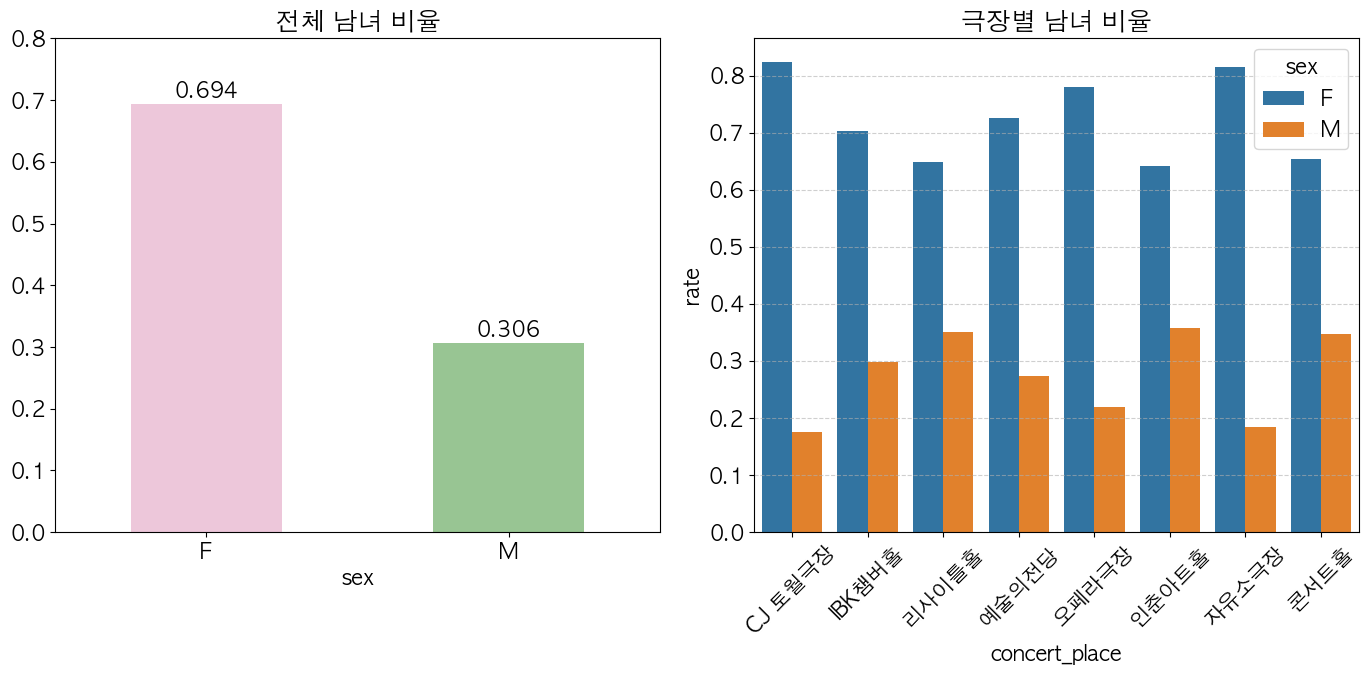

In [21]:
fig, ax = plt.subplots(1,2,figsize=(14,7))

# 남녀의 비율
df["sex"].value_counts(normalize=True).plot.bar(ax=ax[0],color=["#EDC7DA","#98C593"])
ax[0].set_title("전체 남녀 비율")
for idx,val in enumerate(df["sex"].value_counts(normalize=True)):
    ax[0].text(idx, val+0.01, f"{val:.3f}", ha="center")
ax[0].set_ylim(0.0,0.8)
ax[0].tick_params(axis="x", rotation=0)

# 극장별 남녀 비율
df_total = df.groupby("concert_place")["payment_amount"].sum().reset_index()
df_total_sex = df.groupby(["concert_place", "sex"])["payment_amount"].sum().reset_index()
df_total_sex = df_total_sex.merge(df_total, how="left", on="concert_place")
df_total_sex["rate"] = df_total_sex["payment_amount_x"] / df_total_sex["payment_amount_y"]

sns.barplot(
    data=df_total_sex,
    x = "concert_place",
    y = "rate",
    hue = "sex",
    ax=ax[1]
)
ax[1].tick_params(axis="x", rotation=45)
ax[1].set_title("극장별 남녀 비율")
ax[1].grid(axis="y", ls="--", alpha=0.6)
plt.tight_layout()
plt. show()

```
시간의 흐름에 따라 매출 추이 변화 분석해보기
```

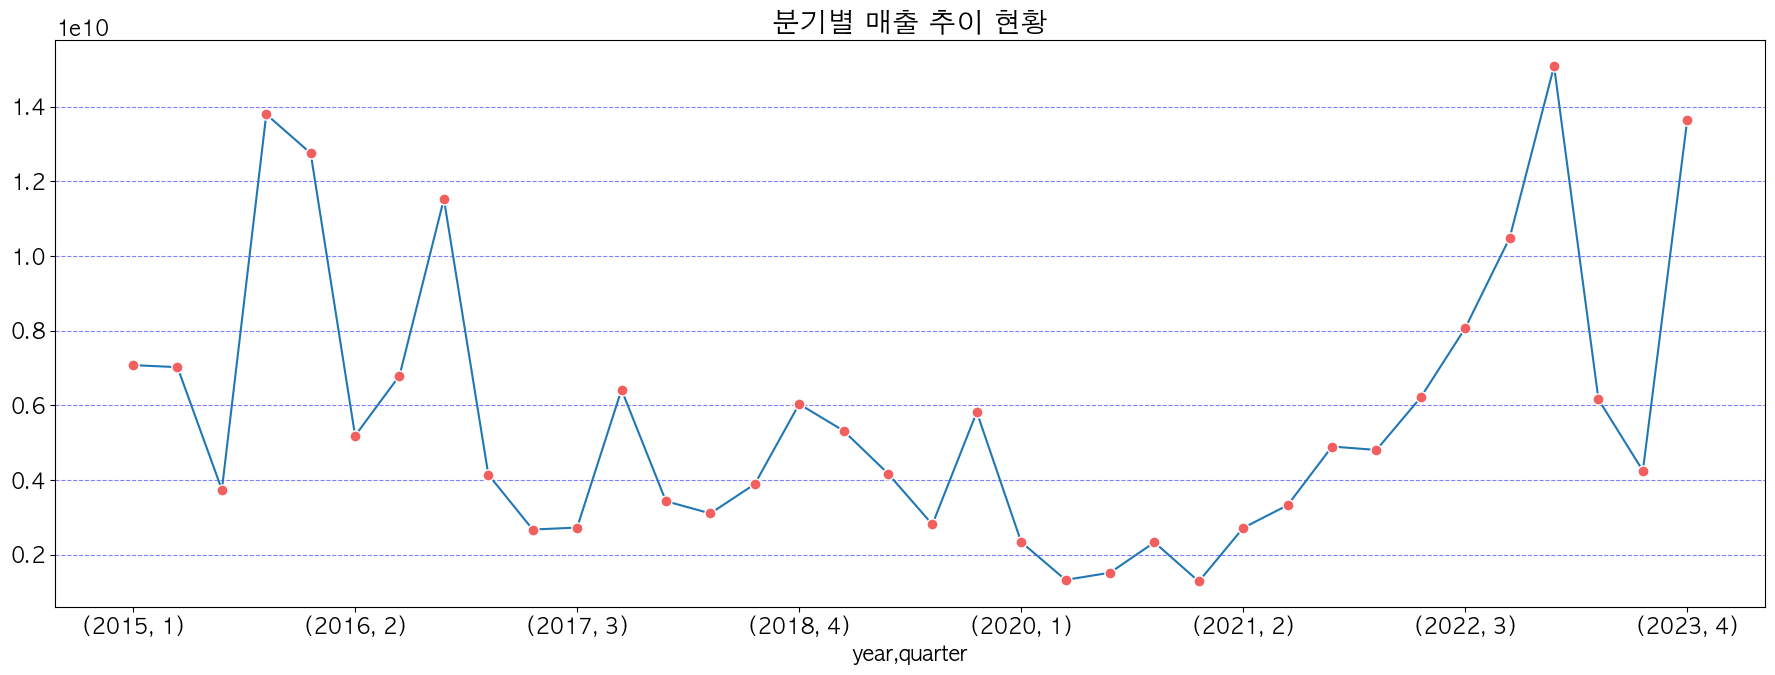

In [22]:
fig, ax = plt.subplots(figsize=(18,7))
df.groupby(["year","quarter"])["payment_amount"].sum().plot(marker='o',
                                                            ms = 8,
                                                            mfc="#F15F5F",
                                                            mec="white",
                                                            ax=ax)
ax.grid(axis="y",ls="--",color="blue",alpha=0.5)
ax.set_title("분기별 매출 추이 현황", size=20)

plt.tight_layout()
plt.show()

```
위 데이터에서 코로나 시기에 매출 급감현상을 볼 수 있었음
만약 같은 전염병이 또 일어난다면 어떻게 해야 최대한 매출급감을 막을 수 있을 것인가!?!? > 공연 기획의 마켓팅 전략 수립
시간의 흐름에 따라 유행 장르의 추이 변화 분석해보기
```

In [166]:
df_2015 = df[df["year"] == 2015].groupby("year")["genre"].value_counts().head()
df_2015

year  genre
2015  클래식      188292
      교향곡       87592
      뮤지컬       75002
      발레        72792
      오페라       39514
Name: count, dtype: int64

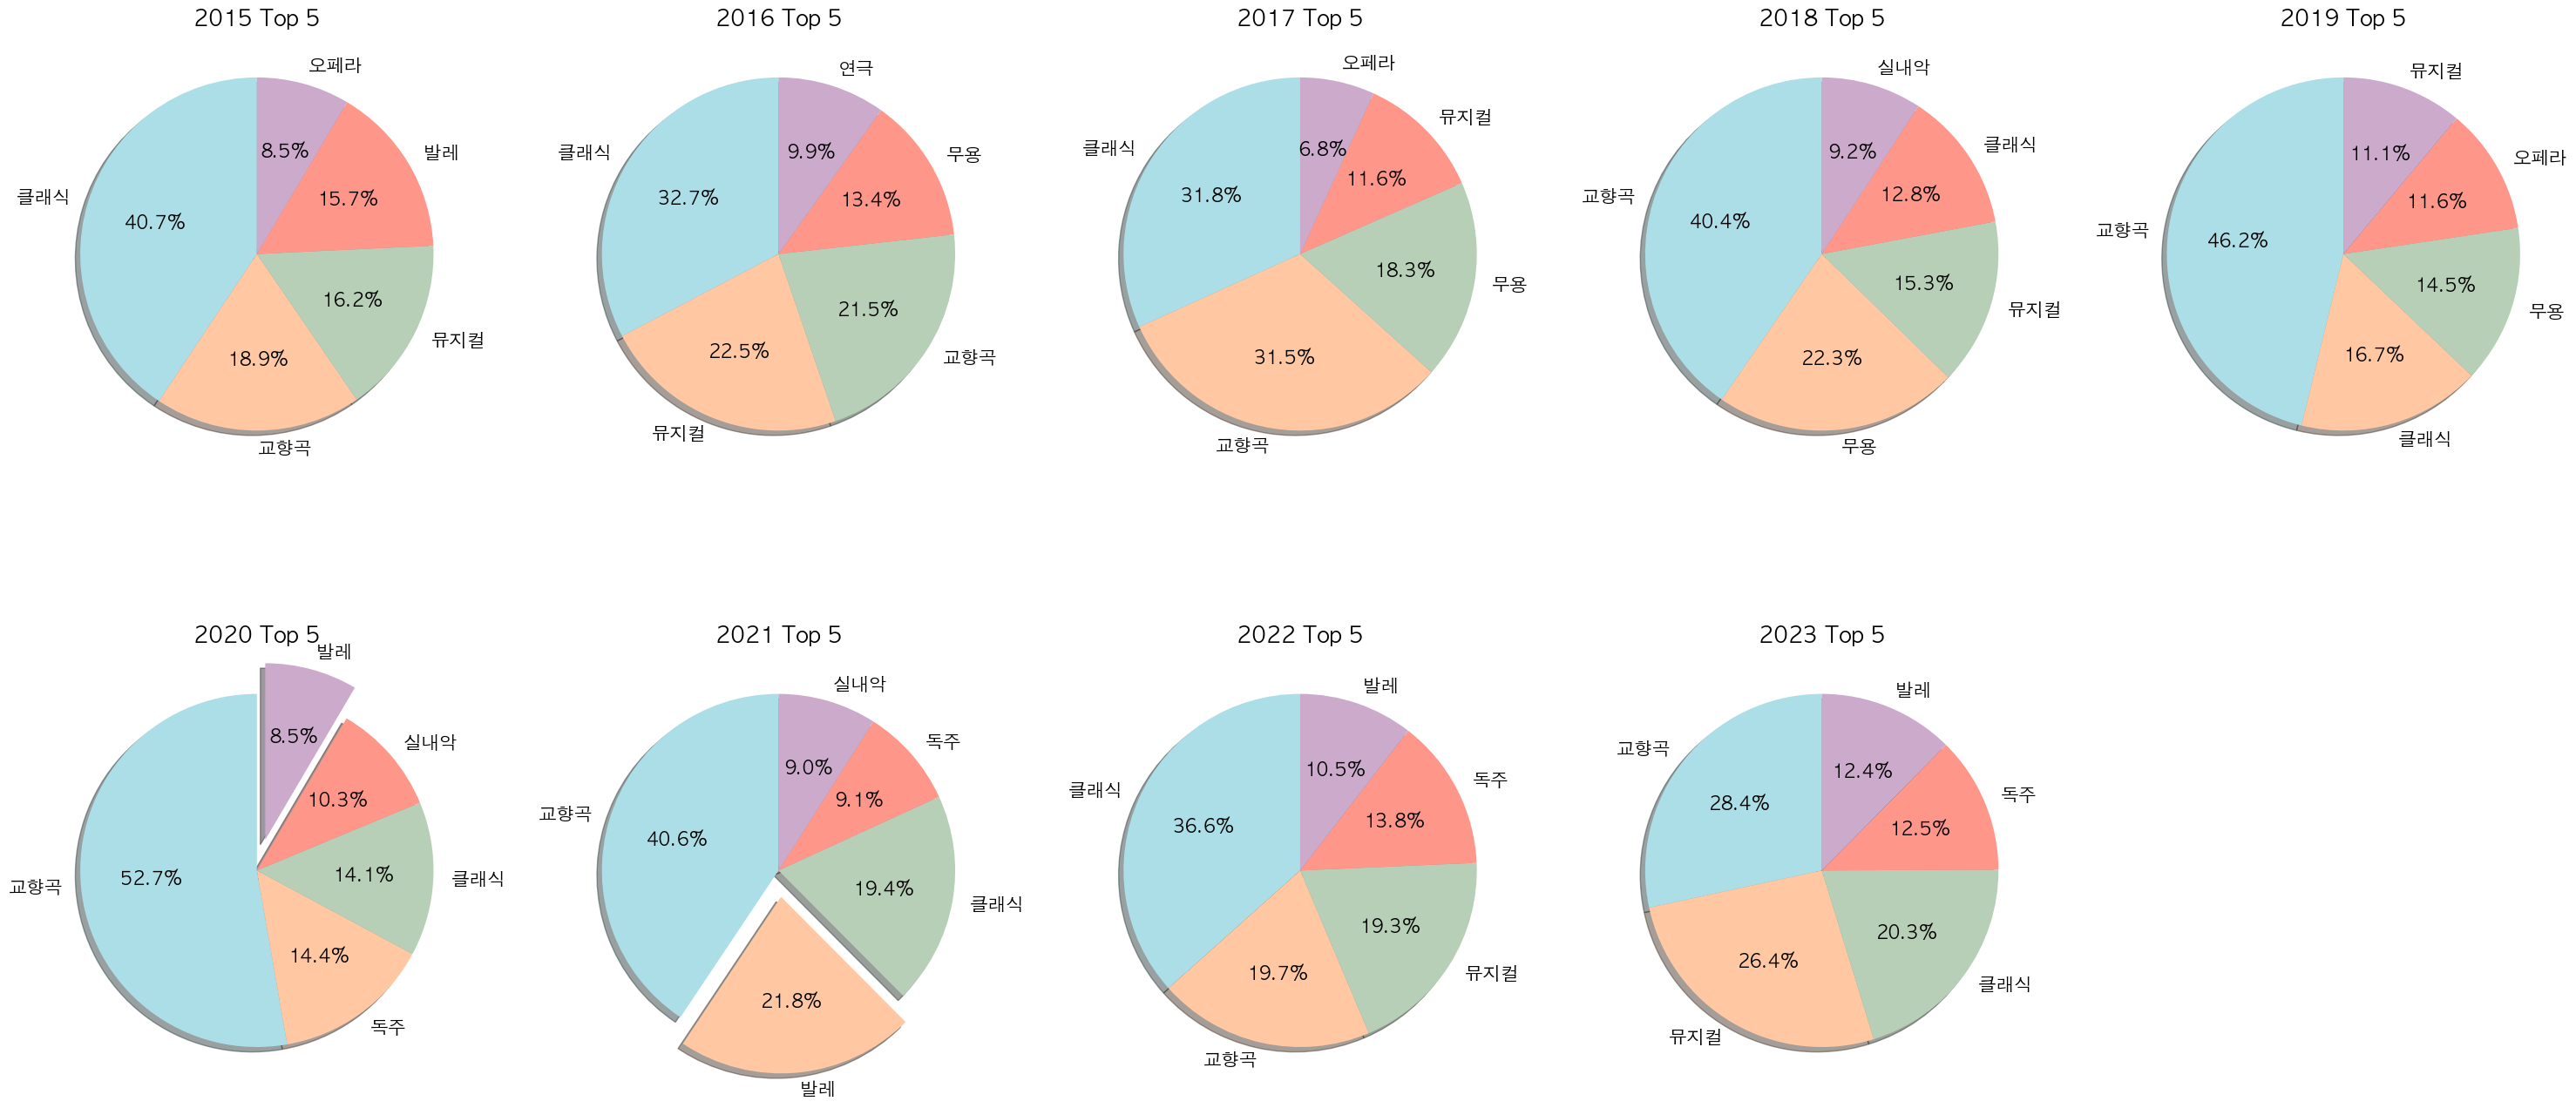

In [23]:
# 각 연도에 대해서 장르별 탑 5 변수 저장
df_2015 = df[df["year"] == 2015].groupby("year")["genre"].value_counts().head()
df_2016 = df[df["year"] == 2016].groupby("year")["genre"].value_counts().head()
df_2017 = df[df["year"] == 2017].groupby("year")["genre"].value_counts().head()
df_2018 = df[df["year"] == 2018].groupby("year")["genre"].value_counts().head()
df_2019 = df[df["year"] == 2019].groupby("year")["genre"].value_counts().head()
df_2020 = df[df["year"] == 2020].groupby("year")["genre"].value_counts().head()
df_2021 = df[df["year"] == 2021].groupby("year")["genre"].value_counts().head()
df_2022 = df[df["year"] == 2022].groupby("year")["genre"].value_counts().head()
df_2023 = df[df["year"] == 2023].groupby("year")["genre"].value_counts().head()

# 위 변수들을 시각화
colors = ["#ABDEE6", "#FFC8A2", "#B6CFB6", "#FF968A", "#CBAACB"]
fig, ax = plt.subplots(2,5, figsize=(30,15))
labels = df_2015.reset_index()["genre"]
ax[0,0].pie(df_2015,labels = labels, autopct="%.1f%%",colors=colors,shadow=True,startangle=90)
ax[0,0].set_title("2015 Top 5")

labels = df_2016.reset_index()["genre"]
ax[0,1].pie(df_2016,labels = labels, autopct="%.1f%%",colors=colors,shadow=True,startangle=90)
ax[0,1].set_title("2016 Top 5")

labels = df_2017.reset_index()["genre"]
ax[0,2].pie(df_2017,labels = labels, autopct="%.1f%%",colors=colors,shadow=True,startangle=90)
ax[0,2].set_title("2017 Top 5")

labels = df_2018.reset_index()["genre"]
ax[0,3].pie(df_2018,labels = labels, autopct="%.1f%%",colors=colors,shadow=True,startangle=90)
ax[0,3].set_title("2018 Top 5")

labels = df_2019.reset_index()["genre"]
ax[0,4].pie(df_2019,labels = labels, autopct="%.1f%%",colors=colors,shadow=True,startangle=90)
ax[0,4].set_title("2019 Top 5")

labels = df_2020.reset_index()["genre"]
explode = [0,0,0,0,0.18]
ax[1,0].pie(df_2020,labels = labels, autopct="%.1f%%",colors=colors,shadow=True,startangle=90, explode=explode)
ax[1,0].set_title("2020 Top 5")

labels = df_2021.reset_index()["genre"]
explode = [0,0.15,0,0,0]
ax[1,1].pie(df_2021,labels = labels, autopct="%.1f%%",colors=colors,shadow=True,startangle=90, explode=explode)
ax[1,1].set_title("2021 Top 5")

labels = df_2022.reset_index()["genre"]
ax[1,2].pie(df_2022,labels = labels, autopct="%.1f%%",colors=colors,shadow=True,startangle=90)
ax[1,2].set_title("2022 Top 5")

labels = df_2023.reset_index()["genre"]
ax[1,3].pie(df_2023,labels = labels, autopct="%.1f%%",colors=colors,shadow=True,startangle=90)
ax[1,3].set_title("2023 Top 5")

ax[1,4].remove()
plt.tight_layout()
plt.show()

# 코로나 시기에는 뮤지컬 시장이 완전 망했다가 점점 회복한다.
# 왜 뮤지컬이 망했을까?? > 혹시 뮤지컬은 해외에서 들어오는경우가 많은데 그게 다 막혀서??
# 아니면 뮤지컬을 보는 특정 집단군이 코로나 시기에는 공연 관람을 꺼리는가?
# 코로나 시기에 실내악, 발레, 독주의 관람객 숫자가 비교적 상승 > 여기선 대극장에서 많이 하는 뮤지컬과 비교하기 위해 발레를 보기로함.

```
뮤지컬이 해외에서 들어오는
경우가 얼마나 있는지 확인해보기
```

In [24]:
# 2020,2021년도에 실행한 뮤지컬 확인하기

musical_2020_2021 = df[df["year"].isin([2020,2021])]
musical_2020_2021 = musical_2020_2021[musical_2020_2021["genre"]=="뮤지컬"].drop_duplicates("concert_name")[["concert_name", "year"]] # 투어 뮤지컬은 없음.
musical_tour = df[df["genre"]=="뮤지컬"].drop_duplicates("concert_name")
musical_tour[musical_tour["concert_name"].str.contains("인터내셔널")]
musical_tour = musical_tour[musical_tour["concert_name"].str.contains("인터내셔널")]
display(musical_2020_2021) # 코로나 때 행해진 뮤지컬
print()
display(musical_tour) # 해외 투어 뮤지컬

,concert_name,year
1000305,뮤지컬 <웃는 남자>,2020
1000768,뮤지컬 <빅 피쉬> 한국 초연,2020
1066299,다윈 영의 악의 기원,2021
1111363,뮤지컬 <광화문연가>,2021
1121038,"윤동주, 달을 쏘다",2021
1144151,[2021 발레축제] 정형일 Ballet Creative / 다크서클즈 컨템포러리 댄스,2021
1153945,뮤지컬 <굿모닝 독도>,2021
1222732,한화생명과 함께하는 예술의전당 11시 콘서트(3월),2021
1234196,뮤지컬 <올 댓 상하이>,2021
1347214,THE 뮤지컬 <굿모닝 독도>,2020


,concert_name,concert_place,concert_day,concert_time,genre,price_total_information,pay_day,discount_info,payment_amount,grade_name,age,sex,area,refund,con_pay_period,day_of_week,year,month,quarter
574845,뮤지컬 라이온 킹 인터내셔널 투어 - 서울,오페라극장,2022-01-20,193000,뮤지컬,R석 18만원 / S석 15만원 / A석 9만원 / B석 6만원,2021-11-26,기타 할인,142500,무료,40대,F,경기,Y,55,목요일,2022,1,1
1704390,뮤지컬 라이온 킹 인터내셔널 투어 (Musical The Lion King),오페라극장,2019-03-28,200000,뮤지컬,R석 17만원 / S석 14만원 / A석 9만원 / B석 6만원,2018-12-27,기타 할인,112000,무료,50대,M,경기,N,91,목요일,2019,3,1


In [182]:
df["grade_name"].value_counts()

grade_name
무료      1425500
골드       823233
블루       552926
싹틔우미     424960
그린       391056
노블        41673
기타         3807
Name: count, dtype: int64

/var/folders/wg/pfs03z6d2fldfm_zdj5yl8_40000gn/T/ipykernel_84659/4175286739.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


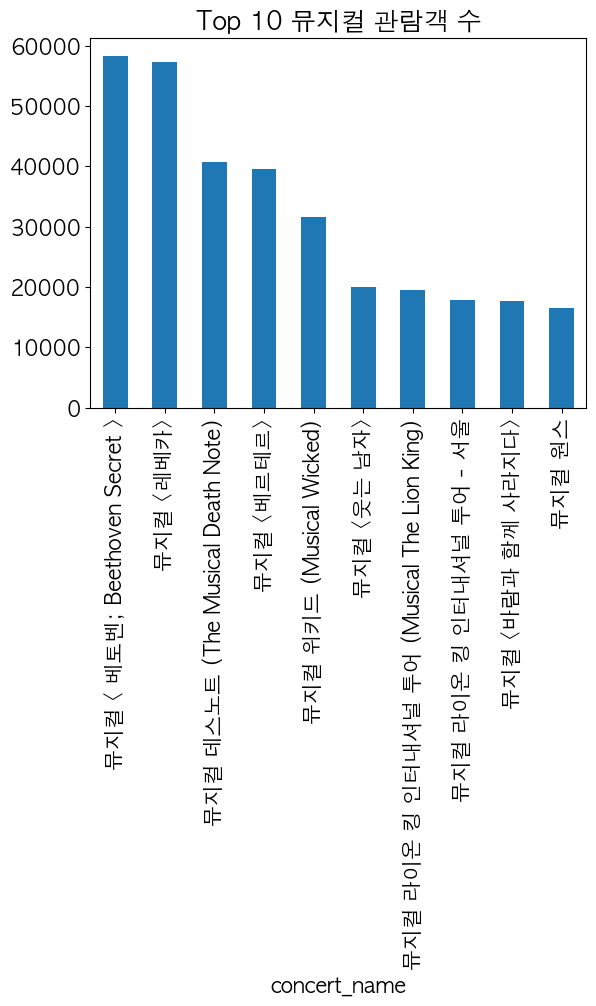

In [25]:
# 각 뮤지컬에 대하여 가장 티켓팅이 많이된 뮤지컬 Top 10를 알아보라

df_musical = df[df["genre"]=="뮤지컬"]
df_musical.groupby("concert_name").size().sort_values(ascending=False).head(10).plot.bar() # 96개의 뮤지컬 공연중 7,8등
plt.xticks(rotation=90)
plt.tight_layout()
plt.title("Top 10 뮤지컬 관람객 수")
plt.show()

```
모든 장르에 대한 비율과
판매 금액 알아보기
```

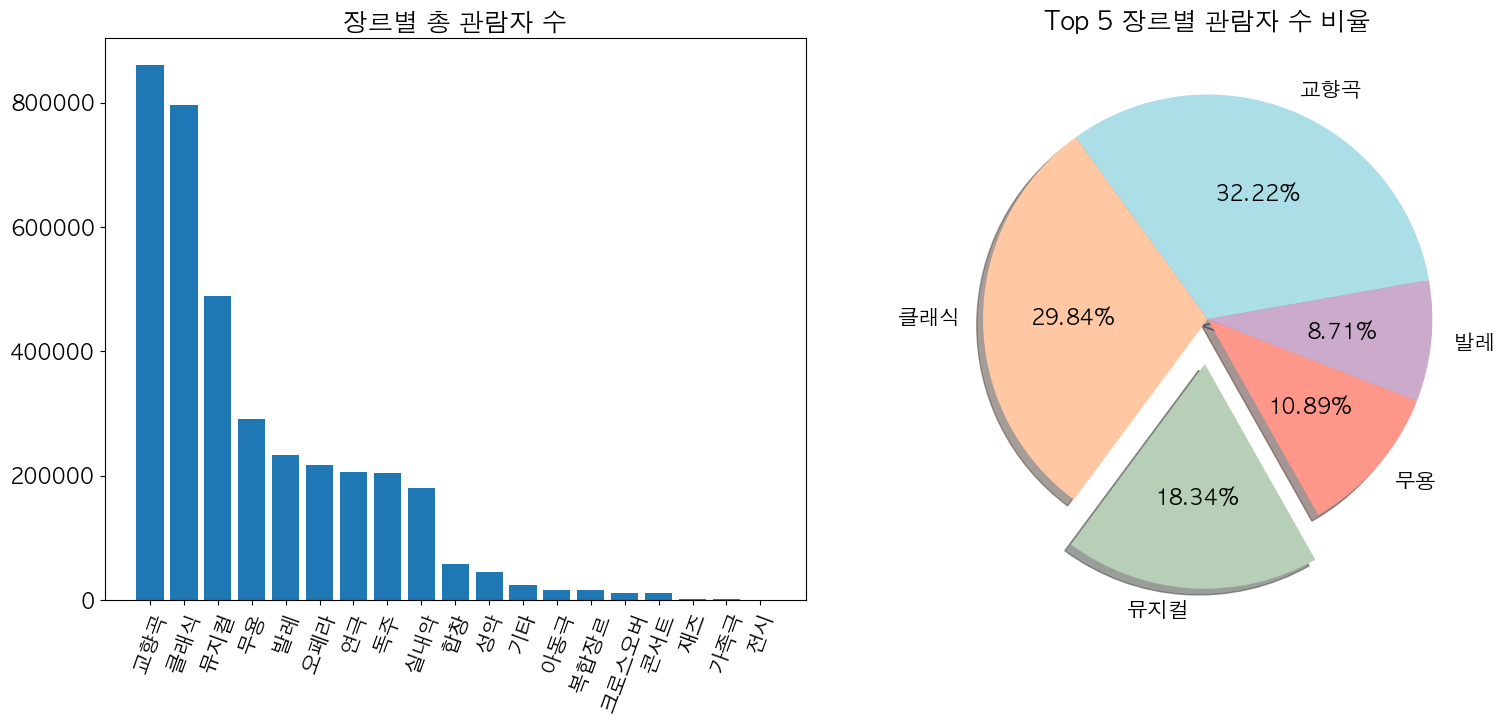

In [26]:
# 각 장르별로 그룹화하여 몇개이고 비율이 어떻게 되는지 코드 작성
df_genre = df.groupby("genre").size().reset_index(name="count")
total = df_genre["count"].sum()
df_genre["total"] = total
df_genre["rate"] = df_genre["count"] / df_genre["total"]
df_genre = df_genre.sort_values("rate",ascending=False)

# 각 장르별 총 매출
df_genre_total = df.groupby("genre")["payment_amount"].sum().reset_index()

# 그래프 그리기
fig, ax = plt.subplots(1,2,figsize=(16,7.5))
ax[0].bar(df_genre["genre"],df_genre["count"])
ax[0].tick_params(axis="x",rotation=70)
ax[0].set_title("장르별 총 관람자 수")

colors = ["#ABDEE6", "#FFC8A2", "#B6CFB6", "#FF968A", "#CBAACB"]
df_genre_head = df_genre["genre"].head()
explode=[0,0,0.2,0,0]
ax[1].pie(df_genre["rate"].head(), labels=df_genre_head,autopct="%.2f%%",startangle=10, shadow=True, colors=colors,explode=explode)
ax[1].set_title("Top 5 장르별 관람자 수 비율")

plt.tight_layout()
plt.show()

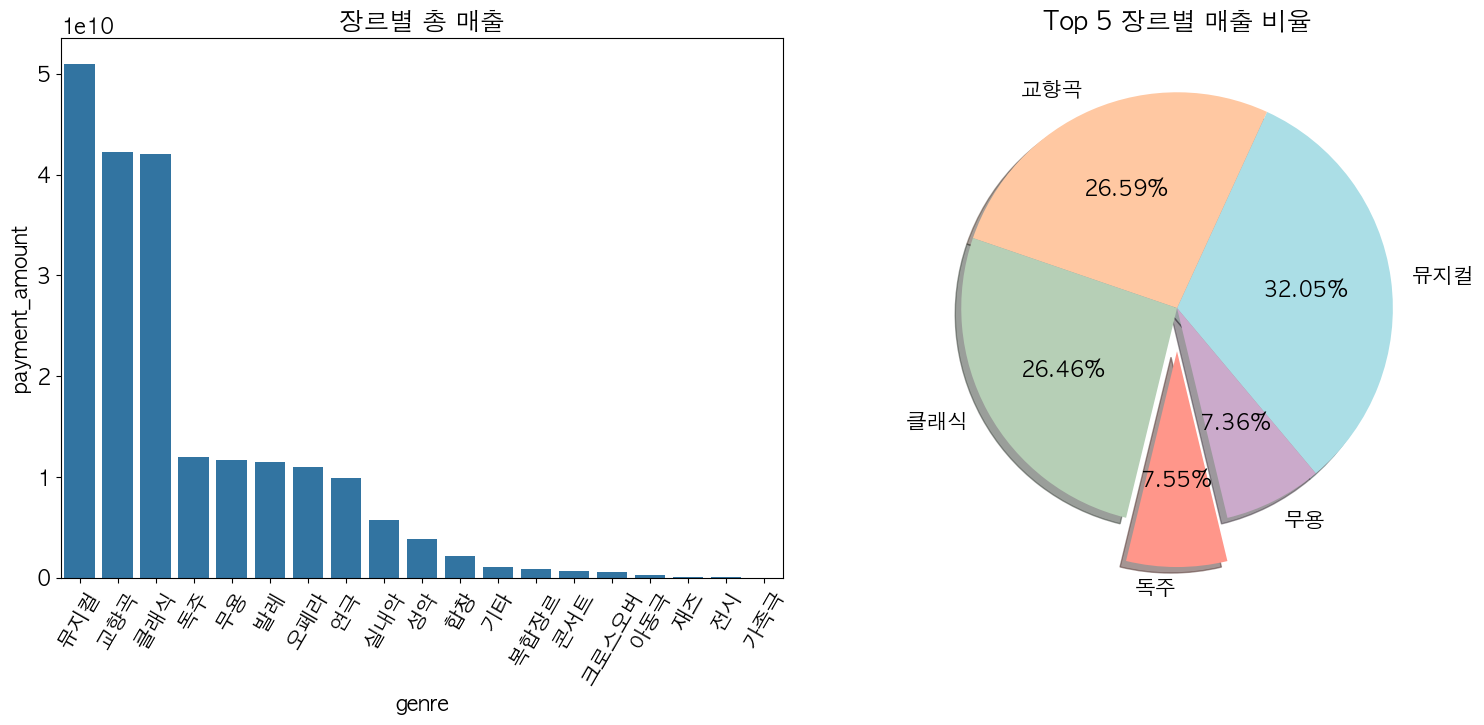

In [27]:
# 장르별 판매 금액

tmp = df.groupby("genre")["payment_amount"].sum().sort_values(ascending=False).reset_index()
fig, ax = plt.subplots(1,2,figsize=(16,7.5))
sns.barplot(
    data=tmp,
    x="genre",
    y="payment_amount",
    ax=ax[0]
    )
ax[0].tick_params(axis="x", rotation=60)
ax[0].set_title("장르별 총 매출")

labels = tmp["genre"].head()
tmp_head = tmp["payment_amount"].head()
explode=[0,0,0.0,0.2,0]
ax[1].pie(tmp_head, labels=labels,startangle=-50,colors=colors,shadow=True,autopct="%.2f%%",pctdistance=0.6,explode=explode)
ax[1].set_title("Top 5 장르별 매출 비율")
plt.tight_layout()
plt.show()

```
뮤지컬을 보는 사람들을
나이와 성별별로 나누어보아라
```

/var/folders/wg/pfs03z6d2fldfm_zdj5yl8_40000gn/T/ipykernel_84659/3374656014.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age_sex_not_head["total_rate"] = df_age_sex_not_head["rate"].sum()
/var/folders/wg/pfs03z6d2fldfm_zdj5yl8_40000gn/T/ipykernel_84659/3374656014.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_musical_not_head["total_rate"] = df_not_musical_not_head["rate"].sum()


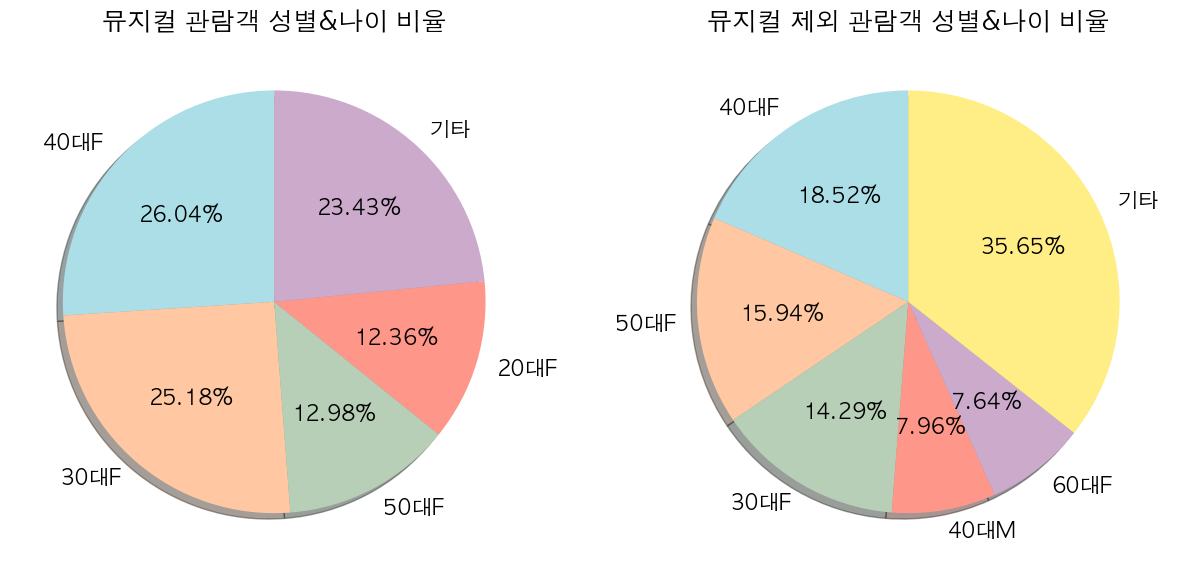

In [28]:
# Top4
df_age_sex = df[df["genre"]=="뮤지컬"].groupby(["age","sex"]).size().reset_index(name="count").sort_values("count",ascending=False)
df_age_sex["total"] = df_age_sex["count"].sum()
df_age_sex["rate"] = df_age_sex["count"] / df_age_sex["total"]
df_age_sex["age_sex"] = df_age_sex["age"] + df_age_sex["sex"]
df_age_sex = df_age_sex.drop(["age","sex"],axis="columns")
df_age_sex = df_age_sex.set_index("age_sex")
df_age_sex_head = df_age_sex.head(4)
df_age_sex_head = df_age_sex_head.reset_index()

# 그외의 성별 및 나이
df_age_sex_not_head = df_age_sex[4:]
df_age_sex_not_head["total_rate"] = df_age_sex_not_head["rate"].sum()
df_age_sex_not_head = df_age_sex_not_head.reset_index()

# Top 4의 정보와 그외 기타로 만들기 위한 코드
a = df_age_sex_not_head["count"].sum()
b = df_age_sex_not_head.loc[0,"total"]
c = df_age_sex_not_head.loc[0,"total_rate"]
series = ({
    "age_sex" : "기타",
    "count" : a,
    "total" : b,
    "rate" : c
})
data = pd.DataFrame(series,index=["기타"]).reset_index().drop("index", axis="columns")
df_concat = pd.concat([df_age_sex_head, data])

# 뮤지컬을 제외한 공연에 대하여 나이와 성별 별로 나누어보아라
filt = df["genre"] == "뮤지컬"
df_not_musical = df[~filt].groupby(["age","sex"]).size().reset_index(name="count").sort_values("count",ascending=False)
df_not_musical["total"] = df_not_musical["count"].sum()
df_not_musical["rate"] = df_not_musical["count"] / df_not_musical["total"]
df_not_musical["age_sex"] = df_not_musical["age"] + df_not_musical["sex"]
df_not_musical = df_not_musical.drop(["age","sex"],axis="columns")
df_not_musical = df_not_musical.set_index("age_sex")
df_not_musical_head = df_not_musical.head()
df_not_musical_head = df_not_musical_head.reset_index()

# 그외의 성별 및 나이
df_not_musical_not_head = df_not_musical[5:]
df_not_musical_not_head["total_rate"] = df_not_musical_not_head["rate"].sum()
df_not_musical_not_head = df_not_musical_not_head.reset_index()

# Top 4의 정보와 그외 기타로 만들기 위한 코드
d = df_not_musical_not_head["count"].sum()
e = df_not_musical_not_head.loc[0,"total"]
f = df_not_musical_not_head.loc[0,"total_rate"]
series = ({
    "age_sex" : "기타",
    "count" : d,
    "total" : e,
    "rate" : f
})
data1 = pd.DataFrame(series,index=["기타"]).reset_index().drop("index", axis="columns")
df_concat1 = pd.concat([df_not_musical_head, data1])

# 시각화
fig, ax = plt.subplots(1,2, figsize=(15,8))
labels=df_concat["age_sex"]
colors = ["#ABDEE6", "#FFC8A2", "#B6CFB6", "#FF968A", "#CBAACB"]
ax[0].pie(df_concat["rate"],labels=labels, autopct="%.2f%%", colors=colors, startangle=90, shadow=True)
ax[0].set_title("뮤지컬 관람객 성별&나이 비율")

labels=df_concat1["age_sex"]
colors = ["#ABDEE6", "#FFC8A2", "#B6CFB6", "#FF968A", "#CBAACB", "#FFEE85"]
ax[1].pie(df_concat1["rate"],labels=labels, autopct="%.2f%%", colors=colors, startangle=90, shadow=True)
ax[1].set_title("뮤지컬 제외 관람객 성별&나이 비율")
plt.show()

In [29]:
# 코로나 때 관객수 비율을 알아보자
lst=[2020,2021]
aa = df[df["year"].isin(lst)].groupby(["age","sex"]).size().reset_index(name="count").sort_values("count",ascending=False)
aa["total"] = aa["count"].sum()
aa["rate"] = aa["count"] / aa["total"]
aa[["age","sex","rate"]].head()
# 특정 관객군이 코로나 때 방문이 뜸한 경우는 없었다...

,age,sex,rate
6,40대,F,0.191785
8,50대,F,0.141597
4,30대,F,0.132141
2,20대,F,0.090363
9,50대,M,0.087642


```
장르가 발레와 뮤지컬일 때
각 콘서트에 대하여 극장별로
열린 횟수를 구하여라
```

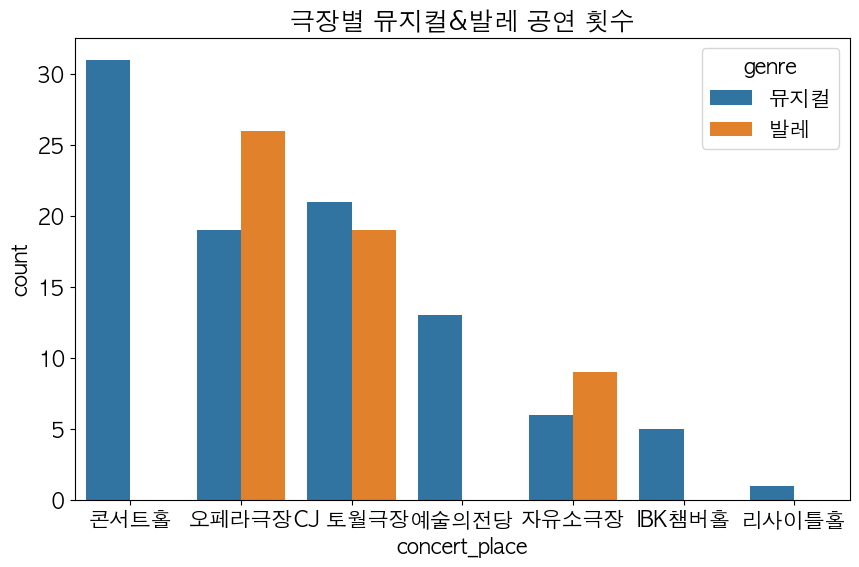

In [30]:
# a극장에서 주로 뮤지컬이 많이 열렸는데 코로나 시기에는 그 극장에서 발레가 열리는 것인가?.
# 이게 맞다면 관객들은 뮤지컬을 보고 싶어도 볼 수 없음.
# 다만 극장이 겹치지 않는다면 자연스럽게 뮤지컬 관심도가 > 발레로 이동 했다. > 결과 X

lst=["발레", "뮤지컬"]
a = df[df["genre"].isin(lst)].drop_duplicates("concert_name").groupby(["concert_place","genre"]).size().reset_index(name="count")
a = a.sort_values("count", ascending=False)
a.groupby("genre")["count"].sum() # 뮤지컬 96 발레 54

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(
    data=a,
    x="concert_place",
    y="count",
    hue="genre",
    ax=ax
)
ax.set_title("극장별 뮤지컬&발레 공연 횟수")

plt.show()

# a_pivot = a.pivot_table(index='concert_place', columns='genre', values='count').fillna(0)
# a_pivot
# a_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
# plt.xticks(rotation=0)
# plt.show()

# 실내악 독주는 비교적 싸니까 코로나 시기에 경제적 부담이 안되는선에서 문화생활은 한게 아닐까??

```
코로나 때 각 극장별로
발레와 뮤지컬의 공연횟수 구하여라
```

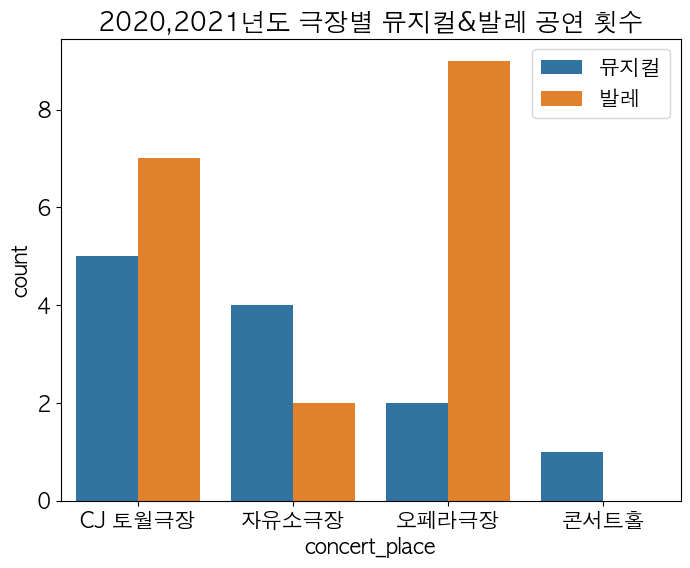

In [31]:
b = df[df["genre"].isin(lst)].drop_duplicates("concert_name")
b = b[b["year"].isin([2020,2021])]
b = b.groupby("genre")["concert_place"].value_counts().reset_index()
b.groupby("genre")["count"].sum() # 뮤지컬 12 발레 18

plt.figure(figsize=(8,6))
sns.barplot(
    data=b,
    x="concert_place",
    y="count",
    hue="genre",
    legend='full'
)
plt.title("2020,2021년도 극장별 뮤지컬&발레 공연 횟수")
plt.legend(fontsize=15)
plt.show()

In [32]:
# 코로나 시기 뮤지컬, 발레에 대하여 극장별로 수익 총합을 구하여라
# 아래 셀에 그래프로 그려놓음

e = df[df["year"].isin([2020,2021])]
e = e[e["genre"].isin(["발레","뮤지컬"])]
e.groupby(["genre","concert_place"])["payment_amount"].sum().reset_index()

,genre,concert_place,payment_amount
0,뮤지컬,CJ 토월극장,334360900
1,뮤지컬,오페라극장,1285738500
2,뮤지컬,자유소극장,35201250
3,뮤지컬,콘서트홀,13075500
4,발레,CJ 토월극장,183112000
5,발레,오페라극장,1975944000
6,발레,자유소극장,9990750


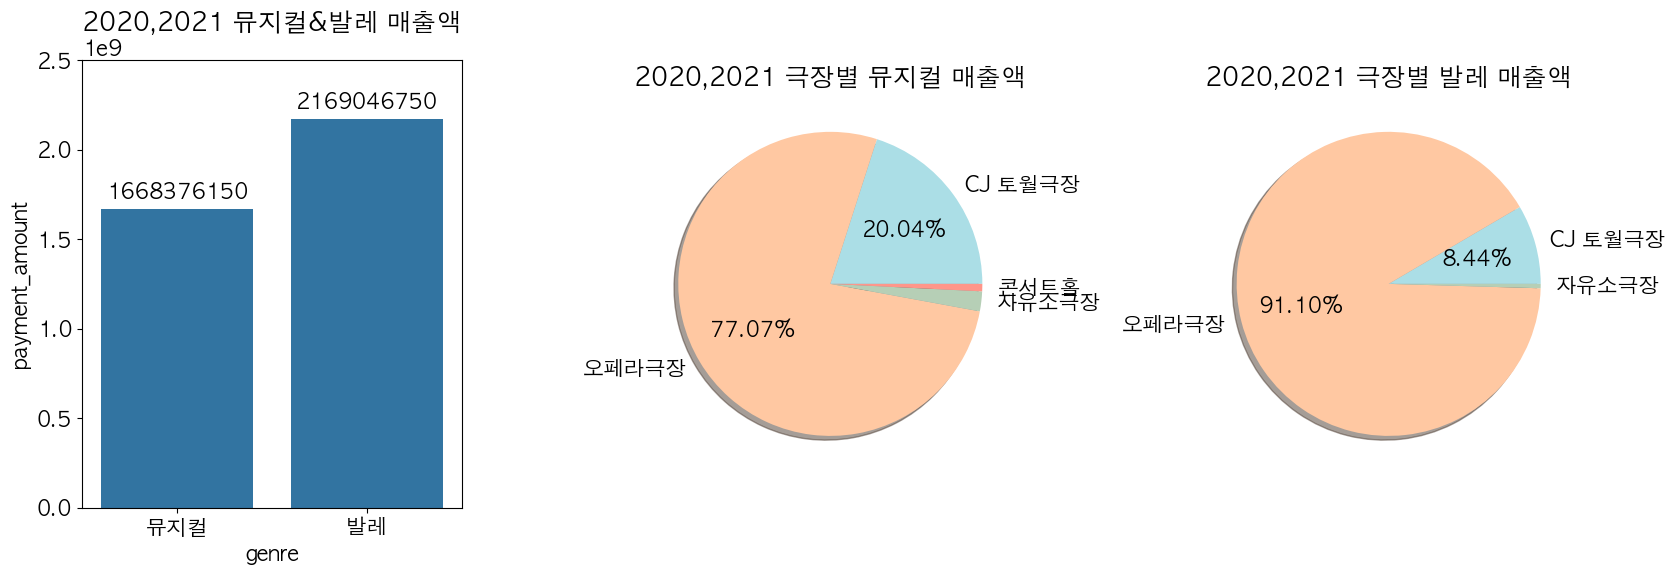

In [33]:
# 코로나때 뮤지컬 전멸 했음. > 그럼 코로나 때 뮤지컬과 발레 매출만 보자
c = df[df["year"].isin([2020,2021])]
c = c[c["genre"].isin(["발레", "뮤지컬"])]
c_graph = c.groupby("genre")["payment_amount"].sum().reset_index()
fig, ax=plt.subplots(1,3,figsize=(17,6))
sns.barplot(
    data=c_graph,
    x="genre",
    y="payment_amount",
    ax=ax[0]
)
ax[0].set_title("2020,2021 뮤지컬&발레 매출액")
ax[0].set_ylim(0,2500000000)
for idx, val in enumerate(c.groupby("genre")["payment_amount"].sum()):
    ax[0].text(idx, val+112115000/2, val, ha="center")
    
# 2020,2021시기 각 극장에 대하여 뮤지컬 수익을 구하여라
c_musical = c[c["genre"]=="뮤지컬"]
c_musical = c_musical.groupby("concert_place")["payment_amount"].sum()

def autopct_func(pct):
    return f'{pct:.2f}%' if pct >= 10 else ''
colors = ["#ABDEE6", "#FFC8A2", "#B6CFB6", "#FF968A"]
ax[1].pie(c_musical,labels=c_musical.index, autopct=autopct_func, colors=colors,shadow=True)
ax[1].set_title("2020,2021 극장별 뮤지컬 매출액")

def autopct_func(pct):
    return f'{pct:.2f}%' if pct >= 5 else ''
c_ballet = c[c["genre"]=="발레"]
c_ballet = c_ballet.groupby("concert_place")["payment_amount"].sum()
colors = ["#ABDEE6", "#FFC8A2", "#B6CFB6", "#FF968A"]
ax[2].pie(c_ballet,labels=c_ballet.index, autopct=autopct_func, colors=colors,shadow=True)
ax[2].set_title("2020,2021 극장별 발레 매출액")

plt.tight_layout()
plt.show()

# 코로나 시기 발레 관람객 숫자는 뮤지컬에 비해 2~3배 높다. 하지만 매출은 관람객 숫자만큼 차이가 존재하진 않는다.

In [34]:
# 관람객 숫자는 코로나 시기 발레가 뮤지컬에 비하여 2~3배 많고 공연또한 1.5배 많다.
# 만약 뮤지컬과 발레의 평균 단가가 똑같았다면 매출은 3.75배가 나오는거로 됩니다.

```
코로나 시기 뮤지컬, 발레 평균 티켓가격 확인하기
```

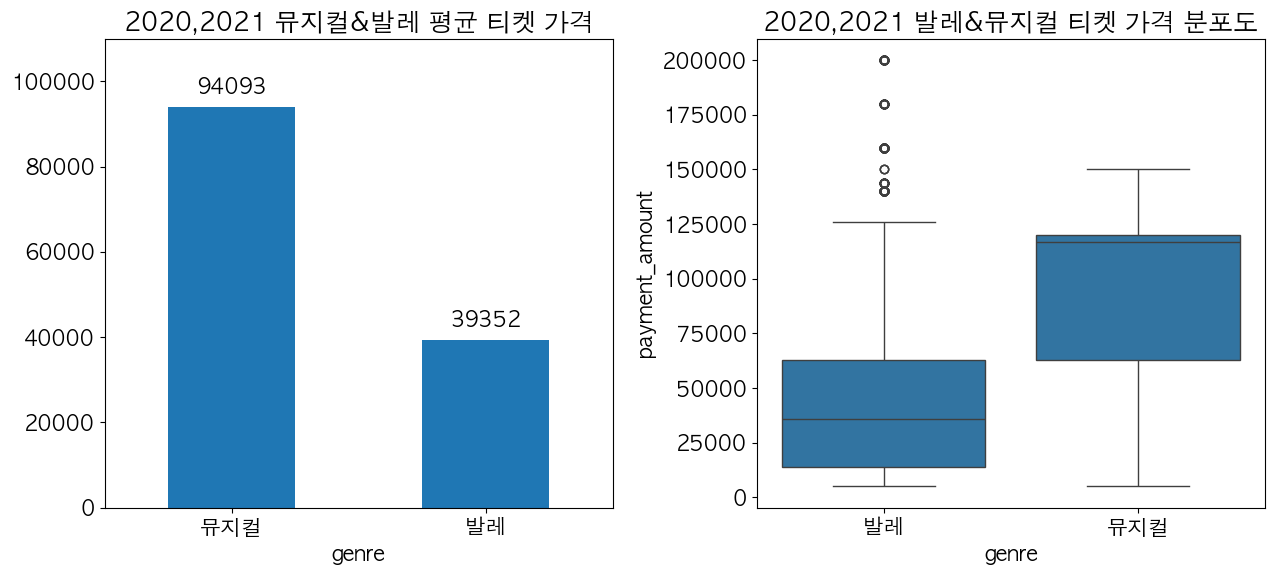

In [35]:
# 코로나 때 뮤지컬, 발레 단가 확인
pay = df[df["year"].isin([2020,2021])]
pay = pay[pay["genre"].isin(["발레", "뮤지컬"])]

pay_int = (pay.groupby("genre")["payment_amount"].mean())
pay_int = pay_int.astype("int64")

fig, ax = plt.subplots(1,2,figsize=(13,6))
pay.groupby("genre")["payment_amount"].mean().plot.bar(ax=ax[0])
ax[0].tick_params(axis="x",rotation=0)
ax[0].set_ylim(0,110000)
for idx, val in enumerate(pay_int):
    ax[0].text(idx, val+3000, val,ha="center")
ax[0].set_title("2020,2021 뮤지컬&발레 평균 티켓 가격")

# 박스플롯을 활용하여 각 공연에 대하여 매출 분포도를 알아보라
sns.boxplot(
    data=c,
    x="genre",
    y="payment_amount",
    ax=ax[1]
)
ax[1].set_title("2020,2021 발레&뮤지컬 티켓 가격 분포도")

plt.tight_layout()
plt.show()

```
위 데이터를 histplot으로 표현
```

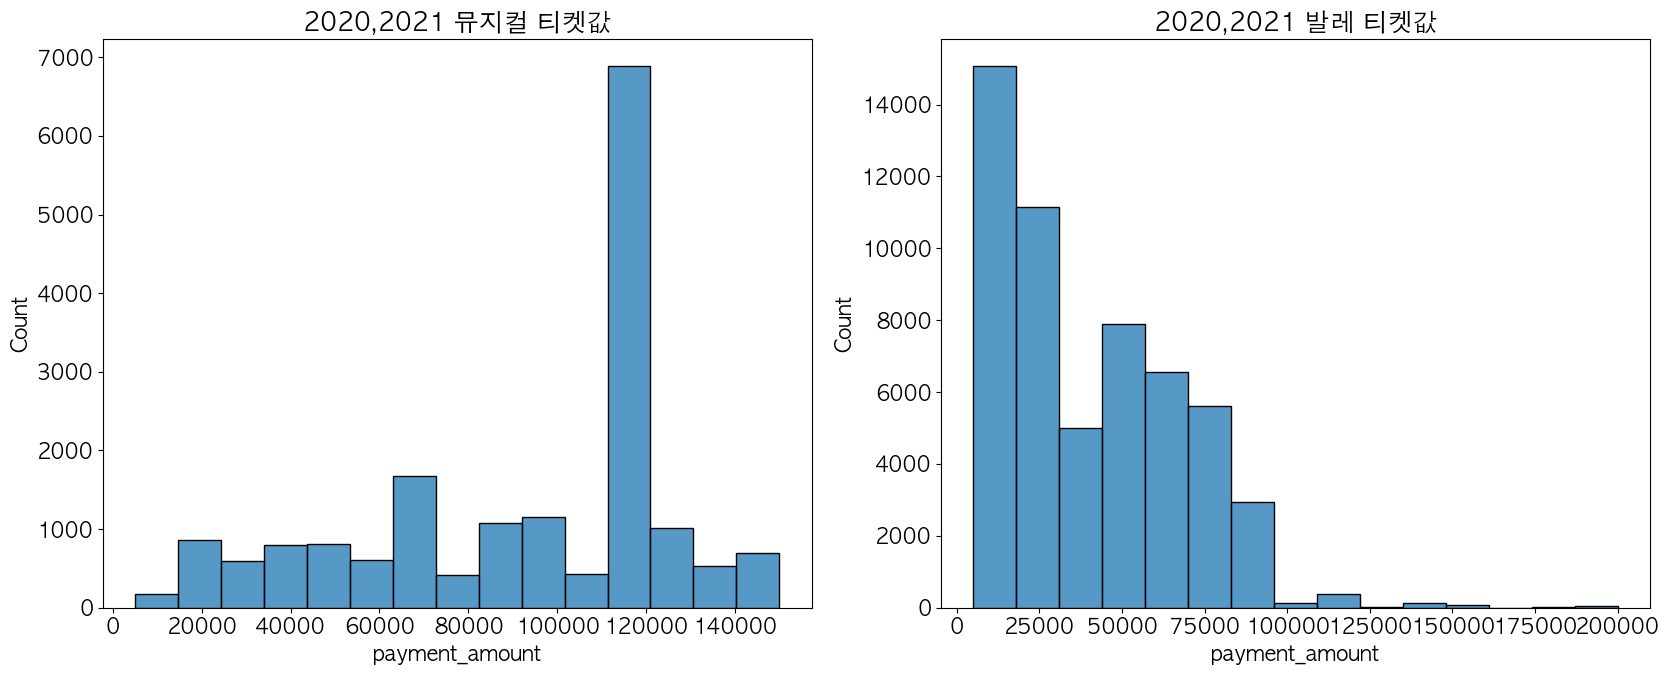

In [36]:
cm = c[c["genre"]=="뮤지컬"]
cb = c[c["genre"]=="발레"]

fig, ax=plt.subplots(1,2,figsize=(17,7))
sns.histplot(
    data=cm,
    x="payment_amount",
    bins=15,
    ax=ax[0]
)
ax[0].set_title("2020,2021 뮤지컬 티켓값")
sns.histplot(
    data=cb,
    x="payment_amount",
    bins=15,
    ax=ax[1]
)
ax[1].set_title("2020,2021 발레 티켓값")
plt.tight_layout()
plt.show()

In [37]:
# 독주 유명한 사람은 >> 조금씬 큰 홀로 옮겨가자 > 이미 콘서트홀에서 할 것 같음... 아마도...? 독주 단가가 좋다면 중극장으로 옮기고 중극장에서 열리는
# 다른 장르의 단가비교해보기
# 코로나 시기 교향곡, 실내악이 큰 극장에서 연주할 경우 단가가 발레보다 훨씬 높다면 굳이 발레를 할 필요가 있을까??? 
# #발레 하지말고 교향곡해라 그래야 돈 더벌수있다. 코로나 시기에. > 마켓팅 전략

```
코로나 시기 각 공연장에 대하여 독주, 실내악의 연주 횟수 구해보기
```

In [38]:
# # 코로나 시기 각 극장별로 독주 공연 연주 횟수 알아보기
# # 공연이름, 장소, 날짜, 시간이 똑같은 것들중 중복된 것은 지우고 그 중 장르가 독주 인 것 만 뽑기
# dfdf = df[df["year"].isin([2020,2021])]
# dfdf = df.drop_duplicates(["concert_name", "concert_place","concert_day","concert_time"])
# dfdf = dfdf[dfdf["genre"]=="독주"]
# dfdf = dfdf.groupby("concert_place").size().sort_values(ascending=False)

# fig,ax = plt.subplots(1,2,figsize=(12,5))
# ax[0].bar(dfdf.index, dfdf)
# for idx, val in enumerate(dfdf):
#     ax[0].text(idx, val+30, val, ha="center")
# ax[0].set_ylim(0,2250)
# ax[0].grid(axis="y",ls="--",alpha=0.7)
# ax[0].set_title("극장별 독주 연주 횟수")

# labels=dfdf.index
# def autopct_format(pct):
#     return f'{pct:.2f}%' if pct > 10 else ''
# colors = ["#ABDEE6", "#FFC8A2", "#B6CFB6", "#FF968A"]
# ax[1].pie(dfdf, labels=labels, colors=colors, shadow = True, autopct=autopct_format,startangle=90)

# plt.tight_layout()
# plt.show()

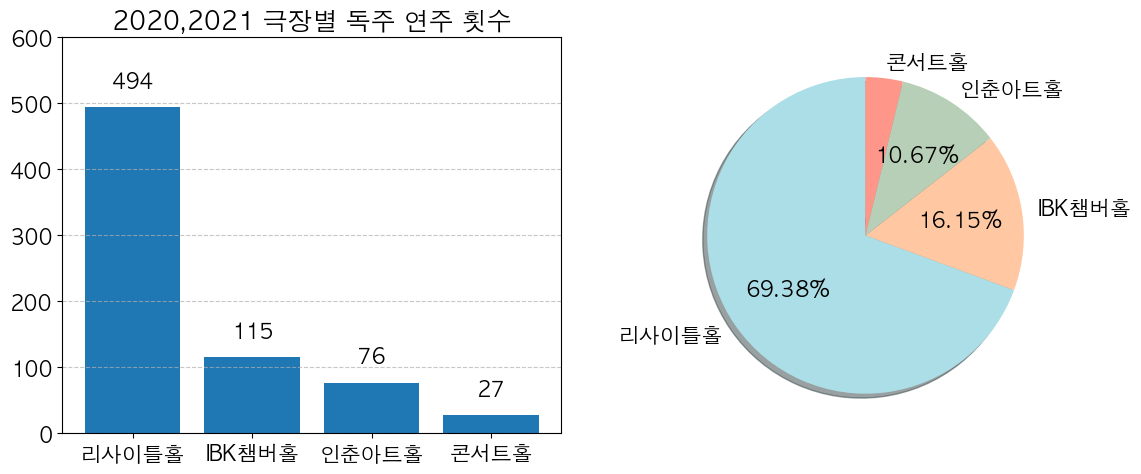

In [39]:
# 코로나 시기 각 연주장에 대한 독주 공연 횟수

zx = df[df["year"].isin([2020,2021])].drop_duplicates(["concert_name","concert_place","concert_day","concert_time"])
zx = zx[zx["genre"]=="독주"]
zx = zx.groupby("concert_place").size().sort_values(ascending=False)

fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].bar(zx.index, zx)
for idx, val in enumerate(zx):
    ax[0].text(idx, val+30, val, ha="center")
ax[0].set_ylim(0,600)
ax[0].grid(axis="y",ls="--",alpha=0.7)
ax[0].set_title("2020,2021 극장별 독주 연주 횟수")

labels=zx.index
def autopct_format(pct):
    return f'{pct:.2f}%' if pct > 10 else ''
colors = ["#ABDEE6", "#FFC8A2", "#B6CFB6", "#FF968A"]
ax[1].pie(zx, labels=labels, colors=colors, shadow = True, autopct=autopct_format,startangle=90)

plt.tight_layout()
plt.show()

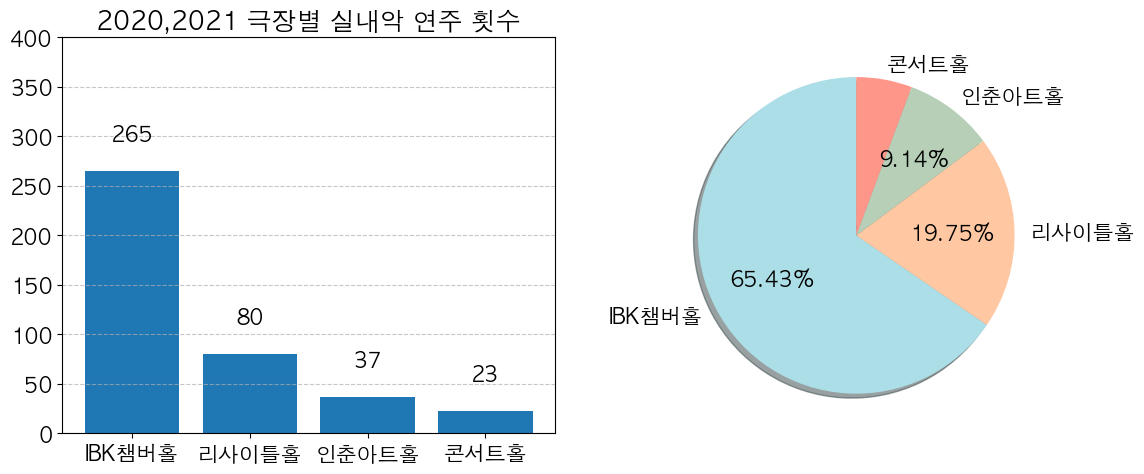

In [40]:
# 코로나 시기 각 극장별로 실내악 공연 연주 횟수 알아보기
ahgdh = df[df["year"].isin([2020,2021])] # 2020,2021년 뽑기
ahgdh = ahgdh.drop_duplicates(["concert_name", "concert_place","concert_day","concert_time"]) # 중복 데이터좀 지우기
ahgdh = ahgdh[ahgdh["genre"]=="실내악"]
ahgdh = ahgdh.groupby("concert_place").size().sort_values(ascending=False)

fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].bar(ahgdh.index, ahgdh)
for idx, val in enumerate(ahgdh):
    ax[0].text(idx, val+30, val, ha="center")
ax[0].set_ylim(0,400)
ax[0].grid(axis="y",ls="--",alpha=0.7)
ax[0].set_title("2020,2021 극장별 실내악 연주 횟수")

labels=ahgdh.index
def autopct_format(pct):
    return f'{pct:.2f}%' if pct > 7 else ''
colors = ["#ABDEE6", "#FFC8A2", "#B6CFB6", "#FF968A"]
ax[1].pie(ahgdh, labels=labels, colors=colors, shadow = True, autopct=autopct_format,startangle=90)

plt.tight_layout()
plt.show()


```
코로나시기 IBK챔버홀, 리사이틀홀에서 열리는 독주와, 실내악의 평균 단가를 알아보자
같은 홀끼리 비교해보고 만약 독주-리사이틀홀 평균단가가 200원, 실내악-리사이틀홀 평균단가가 400원이라면
굳이 리사이틀홀에서 독주를 할 필요가 전혀 없다~
```

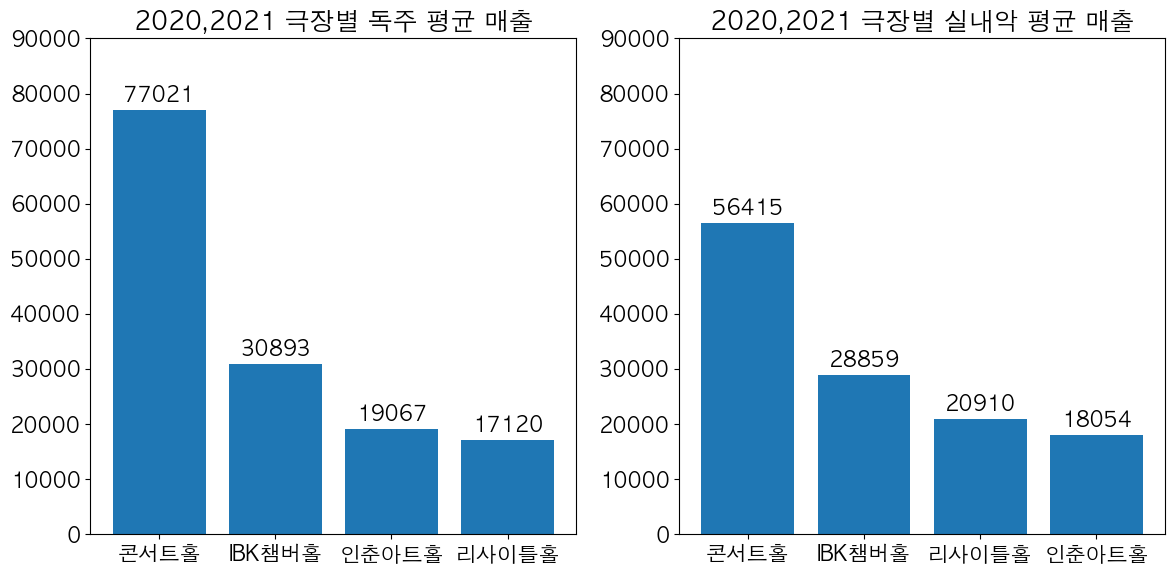

In [41]:
# 코로나시기 극장별 독주 연주회의 평균 매출을 구하여라

tmp=df[df["year"].isin([2020,2021])] # 코로나시기
tmp = tmp[tmp["genre"]=="독주"] # 독주만 뽑음
tmp = tmp.groupby("concert_place")["payment_amount"].mean().sort_values(ascending=False)
tmp = tmp.astype("int64")

# 코로나시기 극장별 실내악 연주회의 평균 매출을 구하여라

tmp2=df[df["year"].isin([2020,2021])] # 코로나시기
tmp2 = tmp2[tmp2["genre"]=="실내악"] #  실내악만 뽑음
tmp2 = tmp2.groupby("concert_place")["payment_amount"].mean().sort_values(ascending=False)
tmp2 = tmp2.astype("int64")

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].bar(tmp.index,tmp)
ax[0].set_ylim(0,90000)
for idx, val in enumerate(tmp):
    ax[0].text(idx, val+1500, val, ha="center")
ax[0].set_title("2020,2021 극장별 독주 평균 매출")

ax[1].bar(tmp2.index,tmp2)
ax[1].set_ylim(0,90000)
for idx, val in enumerate(tmp2):
    ax[1].text(idx, val+1500, val, ha="center")
ax[1].set_title("2020,2021 극장별 실내악 평균 매출") 

plt.tight_layout()
plt.show()

```
위 데이터의 평균매출을 박스플롯으로 그려보기
즉 코로나시기 극장별로 독주, 실내악의 매출 분포 알아보기
```

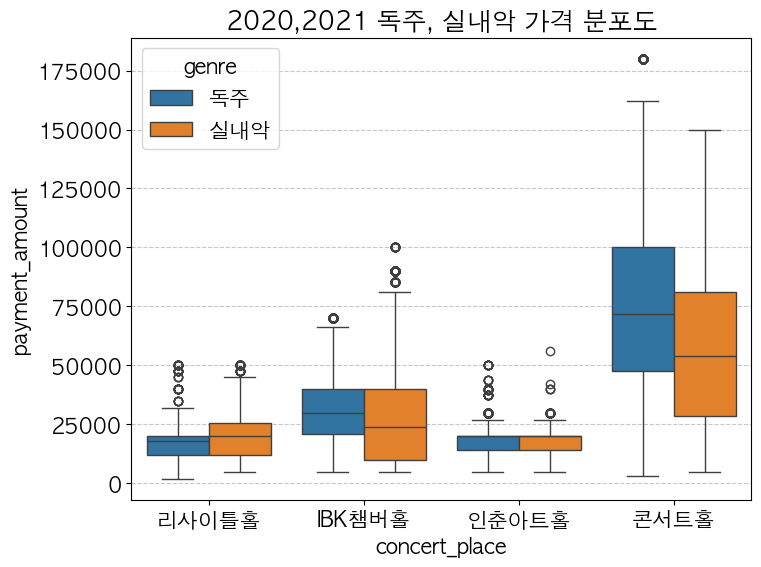

In [42]:
tmp = df[df["year"].isin([2020,2021])] # 코로나시기
tmp = tmp[tmp["genre"].isin(["독주", "실내악"])] # 독주와 실내악만 뽑기
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(
    data=tmp,
    x="concert_place",
    y="payment_amount",
    hue="genre",
    ax=ax
)
ax.grid(axis="y",ls="--", alpha=0.7)
ax.set_title("2020,2021 독주, 실내악 가격 분포도")
plt.show()

# 결론 : 코로나 시기 콘서트홀에서 실내악 할바에는 독주를 해라.

```
코로나시기 교향곡의 극장별 평균 매출과 분포도 알아보라
만약 교향곡의 평균단가가 독주와 차이가 많이 나면 굳이 교향곡을 고집할 필요는 없다.
```

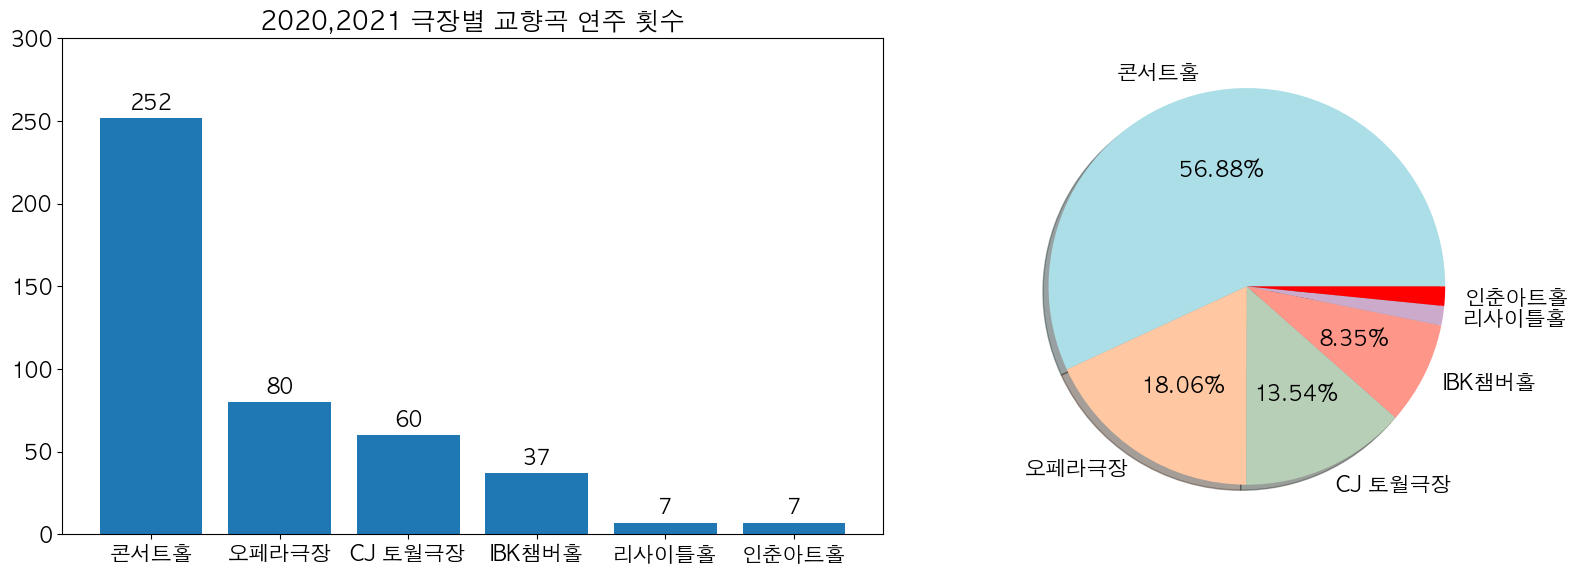

In [43]:
# 코로나시기 극장별로 교향곡의 공연 연주 횟수를 파악해보라

tmp = df[df["year"].isin([2020,2021])] # 코로나시기
tmp = tmp[tmp["genre"]=="교향곡"] #교향곡이
tmp = tmp.drop_duplicates(["concert_name","concert_place", "concert_day", "concert_time"]) # 중복된 데이터 제거
tmp = tmp.groupby("concert_place").size().sort_values(ascending=False)

fig, ax = plt.subplots(1,2,figsize=(17,6))

ax[0].bar(tmp.index, tmp)
ax[0].set_title("2020,2021 극장별 교향곡 연주 횟수")
for idx, val in enumerate(tmp):
    ax[0].text(idx, val+5, val, ha="center")
ax[0].set_ylim(0,300)

labels=tmp.index
def autopct_format(pct):
    return f'{pct:.2f}%' if pct > 7 else ''
colors = ["#ABDEE6", "#FFC8A2", "#B6CFB6", "#FF968A", "#CBAACB","red"]
ax[1].pie(tmp,labels=labels, autopct=autopct_format, colors=colors,shadow=True)

plt.tight_layout()
plt.show()

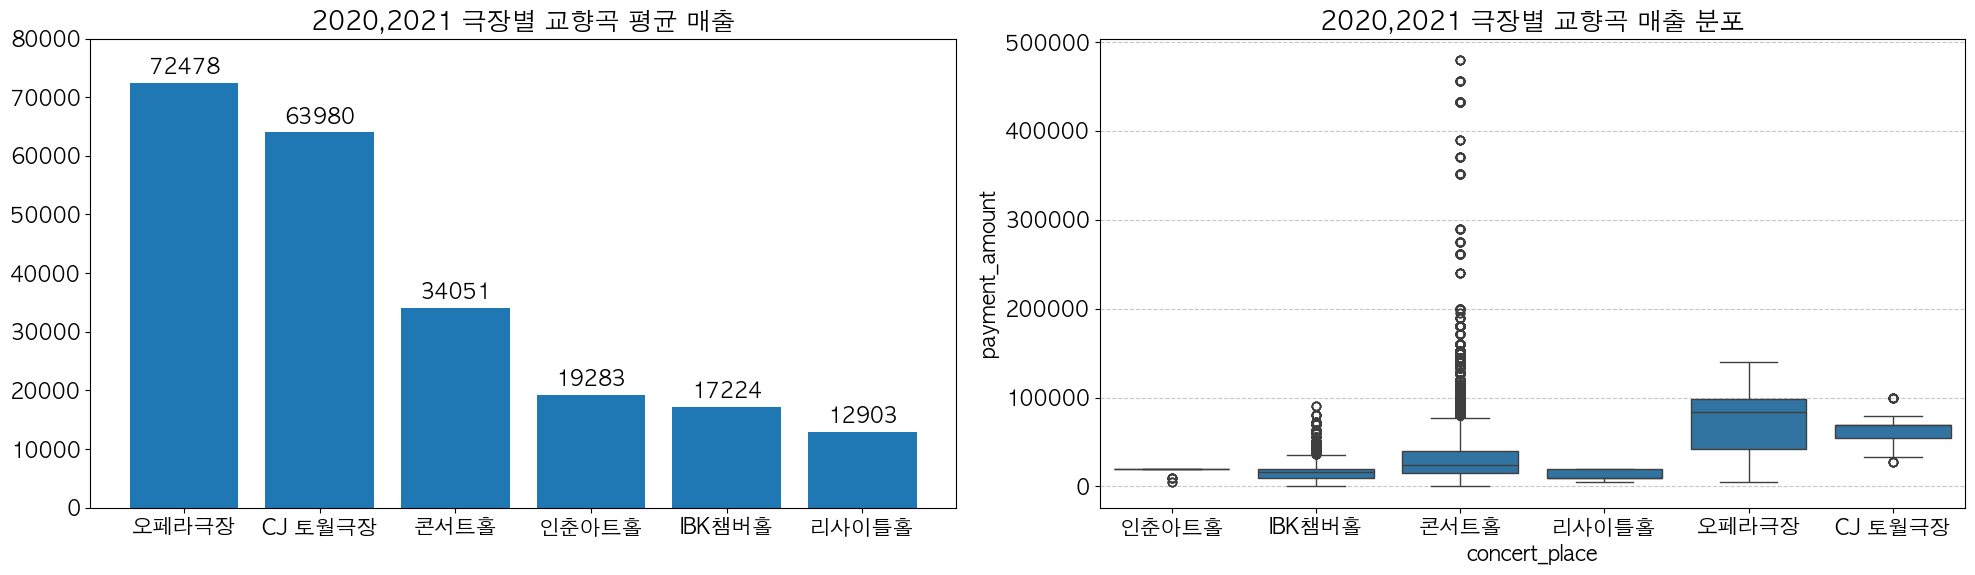

In [44]:
# 코로나 시기 교향곡 극장별 평균 매출, 분포

tmp = df[df["year"].isin([2020,2021])] # 코로나시기
tmp = tmp[tmp["genre"]=="교향곡"] #교향곡이
tmp = tmp.groupby("concert_place")["payment_amount"].mean()
tmp = tmp.sort_values(ascending=False)
tmp = tmp.astype("int64")

fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].bar(tmp.index, tmp)
for idx, val in enumerate(tmp):
    ax[0].text(idx, val+1500, val, ha="center")
ax[0].set_ylim(0,80000)
ax[0].set_title("2020,2021 극장별 교향곡 평균 매출")

tmp2 =df[df["year"].isin([2020,2021])]
tmp2 = tmp2[tmp2["genre"]=="교향곡"]
sns.boxplot(
    data=tmp2,
    x="concert_place",
    y="payment_amount",
    ax=ax[1]
)
ax[1].set_title("2020,2021 극장별 교향곡 매출 분포")
ax[1].grid(axis="y",ls="--",alpha=0.7)

plt.tight_layout()
plt.show()

- 결론 : 코로나 시기 마켓팅 전략
    - 코로나시기 콘서트홀에서 교향곡 대신 독주나 차라리 실내악을 하는 것이 바람직해보임
        - 독주 평균 매출 : 77021, 실내악 평균 매출 : 56415, 교향곡 평균 매출 : 34051
    - 리사이틀 홀 역시 교향곡 보단, 독주나 실내악을 하는 것이 훨씬 유리해보인다.
    - 교향곡은 오페라극장과 CJ 토월극장에서 하는 것이 좋을 듯하다.
    - 독주와